## Models

We can now load in the 4 dataframes for the 4 groups of predictors, and then merge them into a master predictor dataframe. We can then run different models on the master dataframe, and figure out which model is best.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import requests
import sklearn

from collections import Counter

# Import sklearn functions
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

import pickle
import numpy as np

%matplotlib inline

In [4]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

We can load in the original X dataframe, the binarized y target vector, and then all of the dataframes that were cleaned up and dummified in notebook 2.

In [5]:
with open('data/full_X_y_df.pkl', 'rb') as picklefile:
    [X_orig, y] = pickle.load(picklefile)

with open("pkls/dem_hosp_dx_proc_orig_X_dfs.pkl", "rb") as picklefile:
    [X_demographic_predictors_dummified, X_hospital_predictors_df, X_diagnoses_df, X_procedures_df, X] = pickle.load(picklefile)

In [6]:
X_poa_diags = X_diagnoses_df.filter(regex=r'Y', axis=1)
X_not_poa_diags = X_diagnoses_df.filter(regex=r'N', axis=1)

In [7]:
# Let's join all of the dataframes on the index, which is the same for all of them since the row index is the
# record number of the discharge.

X_clean_dummified_full = X_demographic_predictors_dummified.merge(X_hospital_predictors_df, left_index=True, right_index=True)
X_clean_dummified_full = X_clean_dummified_full.merge(X_diagnoses_df, left_index=True, right_index=True)
X_clean_dummified_full = X_clean_dummified_full.merge(X_procedures_df, left_index=True, right_index=True)

In [8]:
print(X_clean_dummified_full.shape)

(12704, 135)


We now perform a gridsearch using different models with different parameters to find the best estimator on the full cleaned & dummified dataframe.

The notebook that goes over part of this is kiwi_detector_code from 7/27/18. But the full example of gridsearchcv with multiple parameter grids was covered in a pair programming notebook: https://github.com/thisismetis/sf18_ds11/blob/master/class_lectures/week04-mcnulty1/05-trees_forests/pair_problem_solution.ipynb

    chi2_selector = SelectKBest(chi2, k=<insert you num_of_vars>)
    chi2_selector.fit_transform(<your input variables>, <your predictor variables> )
    chi2_selector.pvalues_
zip this with your variable names to see the pvals for each

There are a lot of different classifier algorithms that we could try. Let's try the following:
* logistic regression
* SVM
* Naive Bayes
* Decision Tree
* Random Forest

After that:
* PCA for dimensionality reduction -> then try either KNN or logistic regression on the dataset with the reduced dimensions.

After that:
* See if you can figure out H2O.ai, and if so see if their implementations of these algorithms yields different results (particularly random forests, since it sounds like they treat categorical variables differently)

In [98]:
# First, let's split our data set into a training set and a final test set.

X_train, X_test, y_train, y_test = train_test_split(X_clean_dummified_full, y, test_size=0.2, stratify=y)

In [100]:
# The only two variables that are continuous in all of X are patient age (which is actually ordinal, since ages
# are binned into groups, which aren't actually evenly spaced; however I don't think it will have a huge influence
# on the accuracy of the model) and length of stay, which actually is continuous.

# All other variables are either binary/boolean, or are dummy variables that are 0 or 1. Therefore the only two
# columns that will get scaled are patient age and length of stay.

ssX = StandardScaler()

X_train_to_scale = X_train[['pat_age', 'length_of_stay']].copy()
X_train_scaled = ssX.fit_transform(X_train_to_scale)

X_test_to_scale = X_test[['pat_age', 'length_of_stay']].copy()
X_test_scaled = ssX.transform(X_test_to_scale)

X_train.loc[:, 'pat_age'] = X_train_scaled[:, 0]
X_train.loc[:, 'length_of_stay'] = X_train_scaled[:, 1]
X_test.loc[:, 'pat_age'] = X_test_scaled[:, 0]
X_test.loc[:, 'length_of_stay'] = X_test_scaled[:, 1]

/Users/joycelee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [99]:
with open("pkls/X_train_test_y_train_test.pkl", "wb") as picklefile:
    pickle.dump([X_train, X_test, y_train, y_test], picklefile)

In [102]:
X_test['pat_age'].describe()

count    2541.000000
mean       -0.027286
std         0.994323
min        -4.090852
25%        -0.373292
50%         0.157788
75%         0.688868
max         1.485488
Name: pat_age, dtype: float64

In [103]:
X_test['length_of_stay'].describe()

count    2541.000000
mean       -0.001711
std         0.975504
min        -0.568674
25%        -0.568674
50%        -0.291785
75%         0.192771
max        16.044658
Name: length_of_stay, dtype: float64

## GridsearchCV

We'll use gridsearchCV in order to compare the accuracy of different models, and also to use different metrics to score our model. Running KNN and SVC took too long to run, and also it makes no sense to run KNN with 135 predictors.

In [107]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [115]:
models = [
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    print("Doing grid search for {}.".format(name))
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

Doing grid search for logistic.
logistic: best score: 0.796221588113746
Doing grid search for tree.
tree: best score: 0.7980911148282988
Doing grid search for forest.
forest: best score: 0.7735904752533701


In [116]:
with open("pkls/logr_tree_forest_gridsearch.pkl", "wb") as picklefile:
    pickle.dump(grids, picklefile)

In [118]:
svc_parameters = {'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1] , 'probability': [True]}
svc = SVC()
grid = GridSearchCV(svc, cv=5, n_jobs=-1, param_grid=svc_parameters)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1], 'probability': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [119]:
y_preds = grid.predict(X_test)

In [120]:
grid.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [121]:
grid.score(X_train, y_train)

0.9311226999901604

In [122]:
grid.score(X_test, y_test)

0.8276269185360094

In [128]:
grids['svc'] = grid

In [129]:
with open("pkls/logr_tree_forest_svc_gridsearch.pkl", "wb") as picklefile:
    pickle.dump(grids, picklefile)

In [137]:
grids

{'logistic': GridSearchCV(cv=None, error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'C': array([1.00000e-03, 6.57933e-03, 4.32876e-02, 2.84804e-01, 1.87382e+00,
        1.23285e+01, 8.11131e+01, 5.33670e+02, 3.51119e+03, 2.31013e+04,
        1.51991e+05, 1.00000e+06]), 'penalty': ['l1', 'l2']},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0),
 'tree': GridSearchCV(cv=None, error_score='raise',
        estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
          

In [138]:
for name, model in grids.items():
    model.best_estimator_.fit(X_train, y_train)
    y_train_pred = model.best_estimator_.predict(X_train)
    acc_score = accuracy_score(y_train, y_train_pred)
    print("The accuracy for {} on the training set is {}".format(name, str(acc_score)))
    print(classification_report(y_train, y_train_pred))
    
    y_test_pred = model.best_estimator_.predict(X_test)
    acc_score = accuracy_score(y_test, y_test_pred)
    print("The accuracy for {} on the test set is {}".format(name, str(acc_score)))
    print(classification_report(y_test, y_test_pred))
    print("_____________\n")

The accuracy for logistic on the training set is 0.8060612024008659
             precision    recall  f1-score   support

      alive       0.76      0.56      0.64      3177
    expired       0.82      0.92      0.87      6986

avg / total       0.80      0.81      0.80     10163

The accuracy for logistic on the test set is 0.8024399842581661
             precision    recall  f1-score   support

      alive       0.75      0.55      0.64       794
    expired       0.82      0.92      0.86      1747

avg / total       0.80      0.80      0.79      2541

_____________

The accuracy for tree on the training set is 0.795237626685034
             precision    recall  f1-score   support

      alive       0.70      0.60      0.65      3177
    expired       0.83      0.89      0.86      6986

avg / total       0.79      0.80      0.79     10163

The accuracy for tree on the test set is 0.7926013380558835
             precision    recall  f1-score   support

      alive       0.69      0.6

In [198]:
roc_plotting_stuff = []
for name, model in grids.items():
    model.best_estimator_.fit(X_train, y_train)
    preds = model.best_estimator_.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label='expired')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))

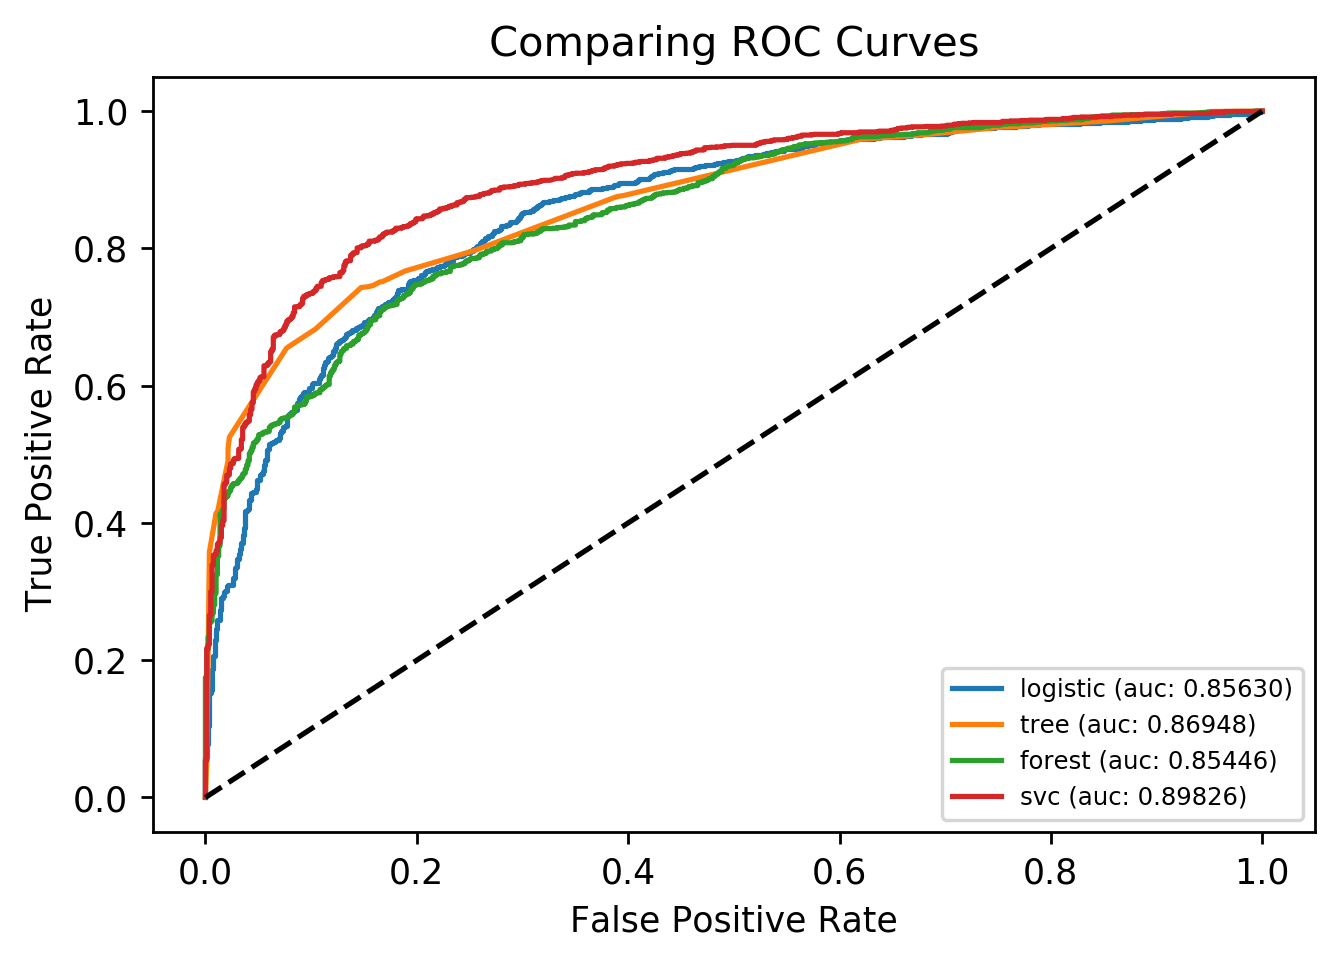

In [199]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.5f)'%auc_score)
plt.legend(loc='lower right', fontsize=7)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

In [155]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris

In [156]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_train, y_train)
y_nb_test_pred = nb.predict(X_test)

In [157]:
accuracy_score(y_test, y_nb_test_pred)
confusion_matrix(y_test, y_nb_test_pred)

array([[ 770,   24],
       [1591,  156]])

Why doesn't naive bayes work? Why is it actually doing worse than the dummy classifier?

In [158]:
# Let's try multi-level perceptron and also perceptron and see how they do.

from sklearn.neural_network import MLPClassifier

In [165]:
mlpc = MLPClassifier(max_iter=1000)

mlpc.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [166]:
mlpc.score(X_train, y_train)

0.9997048115713864

In [201]:
y_mlpc_test_pred = mlpc.predict(X_test)

In [233]:
print(accuracy_score(y_test, y_mlpc_test_pred))
print(confusion_matrix(y_test, y_mlpc_test_pred))
print(classification_report(y_test, y_mlpc_test_pred))

0.8083431719795356
[[ 541  253]
 [ 234 1513]]
             precision    recall  f1-score   support

      alive       0.70      0.68      0.69       794
    expired       0.86      0.87      0.86      1747

avg / total       0.81      0.81      0.81      2541



In [238]:
y_test_num = [int(x=='expired') for x in y_test]
y_mlpc_test_pred_num = [int(x=='expired') for x in y_mlpc_test_pred]

In [240]:
fpr, tpr, _ = roc_curve(y_test_num, y_mlpc_test_pred_num)
auc_score = auc(fpr, tpr)

In [241]:
auc_score

0.7737081488380945

In [242]:
roc_plotting_stuff.append(('mlpc', tpr, fpr, auc_score))

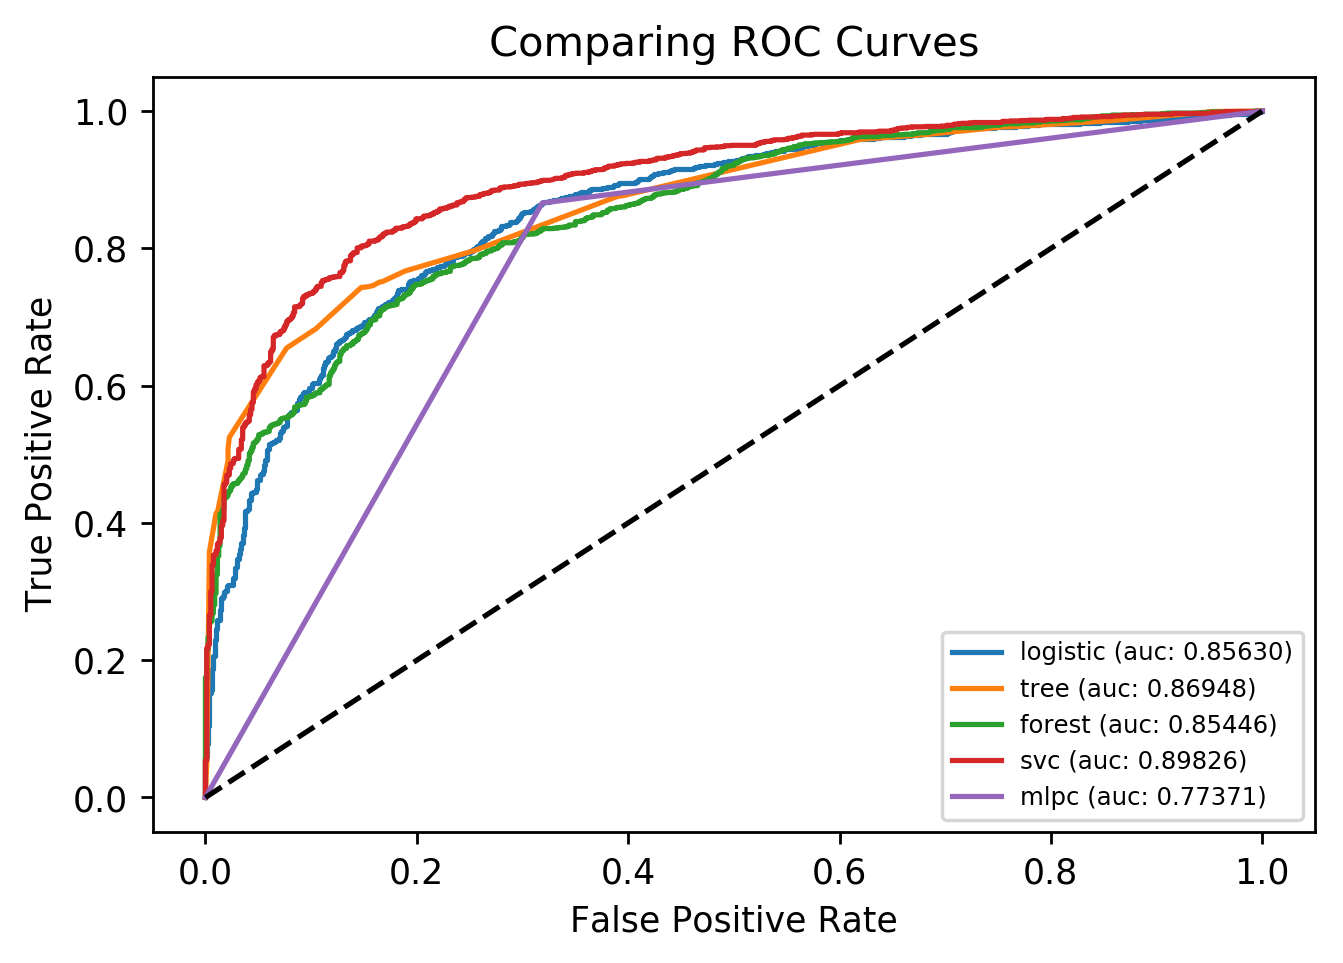

In [244]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.5f)'%auc_score)
plt.legend(loc='lower right', fontsize=7)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

fig = plt.gcf()
fig.savefig('ROC_curves.png')

The next things to tackle here are to 1) try PCA to reduce dimensionality, and then run all these estimators on the pca transformed data points, and compare accuracy. 2) Scramble each column and see how much the accuracy drops for each column (or how much the recall drops, or how much the f1 score drops), and use this to rank importance. 3) Pick the top 50 or so features that have the lowest p values, and re-run the model on that, and see how it works.

In [245]:
from sklearn.decomposition import PCA

In [246]:
pca = PCA(n_components=10)
X_principal_components = pca.fit_transform(X_train)
X_test_principal_components = pca.transform(X_test)

In [247]:
col_names = ['PCA ' + str(i) for i in range(1, 11)]

In [248]:
X_principal_components_df = pd.DataFrame(X_principal_components, columns=col_names)

In [249]:
X_test_principal_components_df = pd.DataFrame(X_test_principal_components, columns=col_names)

In [250]:
X_principal_components_df.shape

(10163, 10)

In [251]:
print(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

[0.10073197 0.07764456 0.04149358 0.03754354 0.0370017  0.033278
 0.03125174 0.03015386 0.02605224 0.02334497]


array([0.10073197, 0.17837653, 0.2198701 , 0.25741364, 0.29441535,
       0.32769335, 0.35894509, 0.38909896, 0.4151512 , 0.43849617])

In [252]:
models = [('svm', SVC),
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'C': [0.1, 1.0, 10],
        'gamma': [0.01, 0.1, 1] ,
        'probability': [True]
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids_pca = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    print("Doing grid search for {}.".format(name))
    grid = GridSearchCV(model(), params)
    grid.fit(X_principal_components_df, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids_pca[name] = grid

Doing grid search for svm.
svm: best score: 0.7823477319689068
Doing grid search for logistic.
logistic: best score: 0.7704417986814917
Doing grid search for tree.
tree: best score: 0.7361015448194431
Doing grid search for forest.
forest: best score: 0.751352946964479


In [189]:
y_pca_logr_test_pred = grids_pca['logistic'].best_estimator_.predict(X_test_principal_components_df)

In [190]:
print(accuracy_score(y_test, y_pca_logr_test_pred))
print(confusion_matrix(y_test, y_pca_logr_test_pred))
print(classification_report(y_test, y_pca_logr_test_pred))

0.7717434081070444
[[ 363  431]
 [ 149 1598]]
             precision    recall  f1-score   support

      alive       0.71      0.46      0.56       794
    expired       0.79      0.91      0.85      1747

avg / total       0.76      0.77      0.76      2541



Now, let's go ahead and scramble each column, and then see how much the auc_score drops.

We'll use gridsearchcv to tune hyperparameters for multiple different classifiers.

Once we find the classifier(s) with the best accuracy, then we can plot the ROC curves. We can also assess the relative feature importance by looking at the largest coefficients in logistic regression, and then also by looking at how the accuracy score changes after scrambling each column (and/or scrambling groups of columns).

Trying the model search from pair programming on 8/2/18:

In [55]:
models = [
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    print("Doing grid search for {}".format(name))
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

Doing grid search for logistic
logistic: best score: 0.8037980911148283
Doing grid search for tree
tree: best score: 0.787857915969694
Doing grid search for forest
forest: best score: 0.7751648135393092


Once you get a sense for which model is actually the best out of KNN, logistic, tree, random forest, and SVC, then run that tree through RFECV to see how well it works.

Then, also use decision tree and/or random forests to get a ranking of which features are the most important. Compare to see which features are identified as the most important.

Then also for the best model identified by gridsearchcv, scramble each feature iteratively and see how the accuracy or f1 score reacts.

In [91]:
y_logr_test_pred = best_logr.predict(X_test)

y_logr_test_probs = best_logr.predict_proba(X_test)

In [96]:
confusion_matrix(y_test, y_logr_test_pred)

array([[ 428,  366],
       [ 172, 1575]])

In [93]:
fpr, tpr, _ = roc_curve(y_test, y_logr_test_probs[:,1], pos_label='expired')
auc_score = auc(fpr, tpr)

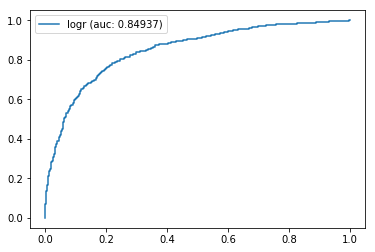

In [95]:
plt.plot(fpr, tpr, label='logr (auc: %.5f)'%auc_score)
plt.legend()
plt.show()

In [59]:
# Let's look at the sorted features for the best logistic regression model that

best_logr = grids['logistic'].best_estimator_
feature_logr_coef = list(zip(X_train.columns, best_logr.coef_[0]))

sorted(feature_logr_coef, key=lambda x: x[1], reverse=True)

[('type_of_admission_4', 4.767113662857658),
 ('first_payment_src_AM', 1.634381497716986),
 (('3481', 'Y'), 1.379614088538368),
 (('3481', 'N'), 1.2108213042943021),
 ('3761', 0.6883732656426947),
 ('source_of_admission_4', 0.6487854807669411),
 (('99592', 'N'), 0.6345214125123042),
 ('9905', 0.5550355458017874),
 ('first_payment_src_VA', 0.4723903000836486),
 ('0017', 0.46732909656322286),
 ('source_of_admission_D', 0.45448901356799953),
 ('9960', 0.4215735761867743),
 ('9915', 0.405147829480716),
 (('2762', 'Y'), 0.40454927805743535),
 (('78552', 'N'), 0.3885443041243609),
 ('9907', 0.384695326154005),
 ('3895', 0.3749084201379404),
 ('first_payment_src_OF', 0.3666901137779276),
 ('hospital_teaching', 0.3662114913295492),
 ('pat_age', 0.3643096415642792),
 ('hospital_community', 0.3593567507565308),
 ('0040', 0.35334662704482367),
 ('source_of_admission_`', 0.3117862545705006),
 ('9604', 0.303189807046428),
 ('source_of_admission_6', 0.29235550125131526),
 (('2762', 'N'), 0.286509483

In [62]:
best_tree = grids['tree'].best_estimator_
feature_tree_coef = list(zip(X_train.columns, best_tree.feature_importances_))

sorted(feature_tree_coef, key=lambda x: x[1], reverse=True)

[('length_of_stay', 0.678160709651732),
 ('8856', 0.07856821508948077),
 ('3722', 0.0656294966267731),
 ('out_of_hospital_cardiac_arrest', 0.06199606594225352),
 ('9672', 0.02963500156042929),
 ('311', 0.023387464003623838),
 (('3481', 'Y'), 0.019623661858194506),
 ('3893', 0.012534630647160502),
 ('pat_age', 0.010561012611314594),
 ('9671', 0.0072995183300943855),
 (('99592', 'N'), 0.003530879136796201),
 ('source_of_admission_4', 0.003012629124273078),
 (('78551', 'N'), 0.0026635976230266144),
 ('public_health_region_08', 0.0008719020297755505),
 (('496', 'Y'), 0.0005799032036890782),
 ('type_of_admission_3', 0.0005674689917885781),
 ('9960', 0.0005612890267805389),
 (('2760', 'N'), 0.00044179162642329147),
 ('type_of_admission_1', 0.00037476291639056895),
 ('sex_code_F', 0.0),
 ('sex_code_M', 0.0),
 ('sex_code_U', 0.0),
 ('race_1', 0.0),
 ('race_2', 0.0),
 ('race_3', 0.0),
 ('race_4', 0.0),
 ('race_5', 0.0),
 ('race_`', 0.0),
 ('ethnicity_1', 0.0),
 ('ethnicity_2', 0.0),
 ('ethnicit

In [63]:
best_forest = grids['forest'].best_estimator_
feature_forest_coef = list(zip(X_train.columns, best_forest.feature_importances_))

sorted(feature_forest_coef, key=lambda x: x[1], reverse=True)

[('length_of_stay', 0.28101729274879156),
 ('8856', 0.0931184462143033),
 ('3722', 0.08653033675289296),
 ('8853', 0.06827116880816102),
 ('311', 0.05230858863181524),
 ('0066', 0.04573710725344467),
 ('4311', 0.04238603663177206),
 ('9671', 0.03387215818254565),
 (('5180', 'N'), 0.026301549461166092),
 (('3481', 'Y'), 0.025583330657496378),
 ('3607', 0.024512408685874575),
 ('pat_age', 0.02280547879822847),
 ('0045', 0.01714515810598291),
 ('9672', 0.01564824161485491),
 ('0040', 0.015013257379954554),
 (('41401', 'Y'), 0.009379684278941886),
 (('2768', 'N'), 0.009361505654431052),
 ('3961', 0.008408972742180993),
 ('9904', 0.007747137391636845),
 (('2762', 'Y'), 0.007505200446427582),
 ('8872', 0.006942892814842319),
 (('2851', 'N'), 0.006754925722132789),
 ('9960', 0.006052280824961577),
 (('0389', 'Y'), 0.005613516317921612),
 (('5849', 'Y'), 0.005213523698963223),
 ('9604', 0.004925062455728932),
 ('3761', 0.004816462583611721),
 ('3995', 0.003688418280662254),
 (('99592', 'Y'), 0

In [67]:
X_clean_dummified_full[X_clean_dummified_full['first_payment_src_AM'] == 1]

,sex_code_F,sex_code_M,sex_code_U,race_1,race_2,race_3,race_4,race_5,race_`,ethnicity_1,...,3761,9390,8872,3607,0045,3324,4311,3404,3961,9915
record_id,,,,,,,,,,,,,,,,,,,,,
120110705976,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320110458877,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420110423897,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
420110428336,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
420110426921,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420110437747,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
420110649470,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [69]:
y[X_clean_dummified_full['first_payment_src_AM'] == 1]

record_id
120110705976    expired
320110458877    expired
420110423897    expired
420110428336    expired
420110426921    expired
420110437747    expired
420110649470    expired
Name: pat_status, dtype: object

In [74]:
automobile_medical = X[X_clean_dummified_full['first_payment_src_AM'] == 1].copy()

In [76]:
automobile_medical['diag_poa_list']

record_id
120110705976    [(86122, Y), (82392, Y), (9580, Y), (4275, Y),...
320110458877    [(9010, Y), (9584, N), (8080, Y), (8074, Y), (...
420110423897    [(3481, Y), (80625, Y), (80600, Y), (34882, N)...
420110428336    [(41051, Y), (4275, Y), (3481, Y), (4271, Y), ...
420110426921    [(85205, Y), (9584, Y), (8600, Y), (0389, N), ...
420110437747    [(90210, Y), (9584, Y), (86803, Y), (8072, Y),...
420110649470    [(80375, Y), (86503, Y), (9584, Y), (4275, Y),...
Name: diag_poa_list, dtype: object

In [89]:
clinical_tables_query = "https://clinicaltables.nlm.nih.gov/api/icd9cm_dx/v3/search?terms={}"

for index, diag_poa_list in automobile_medical['diag_poa_list'].iteritems():
    print(index)
    for diag_poa in diag_poa_list:
        if diag_poa[0]:
            response = requests.get(clinical_tables_query.format(diag_poa[0]))
            val = response.json()
            print(val[3][0][1].strip())
    print("\n")

120110705976
Laceration of lung without mention of open wound into thorax
Open fracture of unspecified part of fibula with tibia
Air embolism
Cardiac arrest
Injury to other and multiple intra-abdominal organs without mention of open wound into cavity
Traumatic hemothorax without mention of open wound into thorax
Injury to spleen without mention of open wound into cavity, unspecified injury
Hemorrhage, unspecified


320110458877
Injury to thoracic aorta
Traumatic shock
Closed fracture of acetabulum
Flail chest
Injury to spleen without mention of open wound into cavity, laceration extending into parenchyma
Traumatic pneumohemothorax without mention of open wound into thorax
Closed fracture of cervical vertebra, unspecified level
Closed fracture of unspecified part of tibia alone
Closed fracture of multiple ribs, unspecified
Cardiac arrest
Closed fracture of scapula, unspecified part
Contusion of heart without mention of open wound into thorax
Congestive heart failure, unspecified
Alcohol